# Machine Learning
### Exercise 3.8 Deep Learning

* Adam Böröndy 01610133
* Markus Sieder 01610682

Links and References

https://github.com/tuwien-musicir/DeepLearning_Tutorial/blob/master/Car_recognition.ipynb (Neural Networks)

https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html (HOG Feature Extraction)



In [1]:
import glob
import os

from PIL import Image
import time

import seaborn as sn
import matplotlib.pyplot as plt



import numpy as np
import pandas as pd

# Classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix


#HOG extraction
from skimage.feature import hog
from skimage import data, exposure

# CNN
from keras.models import Sequential
from keras.layers import MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D as Conv2D
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

owd=os.getcwd()  #Sets the old working dir so we can go back later
#only execute once!!! otherwise have to restart kernel

Using TensorFlow backend.


# Traffic Sign Dataset

## Preliminaries

In [2]:
#Set directory
#Change the working directory

imgPath="./GermanTrafficSignDatasetWithBackdoorImages/CleanDataset"
os.chdir(owd)
os.chdir(imgPath)

In [3]:
#Get all filenames within the training/testing set (Will be used for reading in in a later step)
#We load in both at the same time because some classes are empty for train/test set and we have to
#sample ourselves

imgFiles = glob.glob("*/*/*.ppm")


In [4]:
#Reading in a single Folder

#image_list = []
#for filename in glob.glob('./GermanTrafficSignDatasetWithBackdoorImages/CleanDataset/train/Stop/*.ppm'):
#    im=Image.open(filename)
#    image_list.append(im)

In [5]:
#
image_list = []
for filename in imgFiles:
    im=Image.open(filename)
    image_list.append(im)

In [6]:
image_list[0:10]

[<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=59x62 at 0x230687B96C8>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=52x50 at 0x230687B9708>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=29x29 at 0x230687B9748>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=27x27 at 0x23068862748>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=60x60 at 0x230688674C8>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=34x34 at 0x2306886CEC8>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=30x30 at 0x23068871C88>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=58x60 at 0x23068872508>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=45x45 at 0x23068872588>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=83x83 at 0x23068867508>]

{'whiskers': [<matplotlib.lines.Line2D at 0x2306c265e88>,
 'caps': [<matplotlib.lines.Line2D at 0x2306c272e48>,
 'boxes': [<matplotlib.lines.Line2D at 0x2306c265308>],
 'medians': [<matplotlib.lines.Line2D at 0x2306c278dc8>],
 'fliers': [<matplotlib.lines.Line2D at 0x2306c278ec8>],
 'means': []}

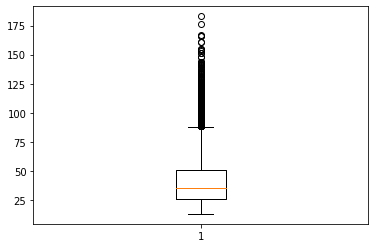

In [7]:
h = []
w = []
for i in image_list:
    width, height = i.size
    h.append(height)
    w.append(width)
    
plt.boxplot(h)

In [8]:
fileNames = glob.glob("*/*/*.ppm")
numberOfFiles=len(fileNames)
targetLabels=[]

print("Found " + str(numberOfFiles) + " files\n")

# The first step - create the ground truth (label assignment, target, ...) 
# For that, iterate over the files, and obtain the class label for each file
# Basically, the class name is in the full path name, so we simply use that


fileNames = [f.replace('test\\', '') for f in fileNames]
fileNames = [f.replace('train\\', '') for f in fileNames]


for fileName in fileNames:

    pathSepIndex = fileName.index("\\")
    targetLabels.append(fileName[:pathSepIndex])

# sk-learn can only handle labels in numeric format - we have them as strings though...
# Thus we use the LabelEncoder, which does a mapping to Integer numbers
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(targetLabels) # this basically finds all unique class names, and assigns them to the numbers
print("Found the following classes: " + str(list(le.classes_)))

# now we transform our labels to integers
target = le.transform(targetLabels); 
print("Transformed labels (first elements: " + str(target[0:150]))

# If we want to find again the label for an integer value, we can do something like this:
# print list(le.inverse_transform([0, 18, 1]))

print("... done label encoding")

Found 6688 files

Found the following classes: ['CanGoStraightAndTurn', 'CycleTrack', 'DoNotEnter', 'GiveWay', 'Parking', 'Pedestrian', 'SpeedLimit', 'Stop', 'TurnLeft', 'TurnRight']
Transformed labels (first elements: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
... done label encoding


## Data Exploration
When plotting the classes we see a very high imbalance betweeen the groups. Group "GiveWay" (3) is the most prominent while "Parking" or "Pedestrian" are underrespresented. This could lead to a problem during model building. A "dumb" classifier would achieve ~37% accuracy by just predicting "GiveWay"

Text(0, 0.5, 'Relative Class Frequency [%]')

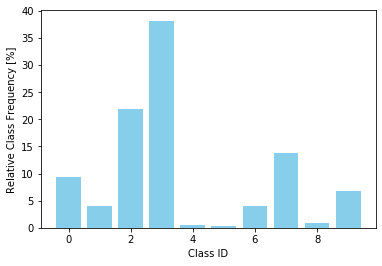

In [9]:
labels = list(map(int, target))
labels = pd.DataFrame(labels)
labels = labels[0].value_counts()
labels = pd.DataFrame(labels)
labels = labels.sort_index(axis=0)
plt.bar(list(labels.index),labels[0]/len(target)*100,color="skyblue")
plt.xlabel ("Class ID")
plt.ylabel ("Relative Class Frequency [%]")

In [10]:
labels

,0
0,630
1,270
2,1470
3,2554
4,36
5,28
6,270
7,920
8,60
9,450


## Sampling
In order to split into train and test sets we will now sample the data:

We chose a 70:30 for our stratified train-test-split.

In [11]:


X_train, X_test, y_train, y_test = train_test_split(image_list, target, test_size=0.3, random_state=42, stratify=target)

In [12]:
print(len(X_train))
print(len(X_test))

4681
2007


## Colour Histogram
* Computation of Colour Histograms
* Random Forests Classification
* MLP Classification

Random Forests were chosen as they overall proved best for the classification task in Exercise 2.

In [13]:
ch_train = []
ch_test = []
start = time.time()
for i in X_train:

    imagePIL = i.convert('RGB')     
    featureVector=imagePIL.histogram()
    ch_train.append((featureVector))
    
for i in X_test:

    imagePIL = i.convert('RGB')     
    featureVector=imagePIL.histogram()
    ch_test.append((featureVector))
end = time.time()
ch_time_preprocessing = end-start

In [14]:
start = time.time()

ch_rf1 = RandomForestClassifier(n_estimators = 50, random_state = 42)
ch_rf1.fit(ch_train,y_train)

end = time.time()
ch_time_rf_build1 = end-start

start = time.time()
ch_rf_pred1 = ch_rf1.predict(ch_test)
end = time.time()
ch_time_rf_pred1 = end-start

In [15]:
start = time.time()

ch_rf2 = RandomForestClassifier(n_estimators = 200, random_state = 42)
ch_rf2.fit(ch_train,y_train)

end = time.time()
ch_time_rf_build2 = end-start

start = time.time()
ch_rf_pred2 = ch_rf2.predict(ch_test)
end = time.time()
ch_time_rf_pred2 = end-start

In [16]:
start = time.time()

ch_mlp1 = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(16, 16), random_state=42)

ch_mlp1.fit(ch_train, y_train)

end = time.time()
ch_time_mlp_build1 = end-start

start = time.time()
ch_mlp_pred1 = ch_mlp1.predict(ch_test)
end = time.time()
ch_time_mlp_pred1 = end-start

In [17]:
start = time.time()

ch_mlp2 = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(126, 32), random_state=42)

ch_mlp2.fit(ch_train, y_train)

end = time.time()
ch_time_mlp_build2 = end-start

start = time.time()
ch_mlp_pred2 = ch_mlp2.predict(ch_test)
end = time.time()
ch_time_mlp_pred2 = end-start

In [18]:
print(accuracy_score(ch_rf_pred1,y_test))
print(accuracy_score(ch_rf_pred2,y_test))
print("********")
print(accuracy_score(ch_mlp_pred1,y_test))
print(accuracy_score(ch_mlp_pred2,y_test))

0.8231190832087693
0.8241155954160438
********
0.23168908819133036
0.17239661185849528


In [19]:
confusion_matrix(y_test, ch_rf_pred1)

array([[174,   0,   4,  11,   0,   0,   0,   0,   0,   0],
       [  0,  20,   9,  47,   0,   0,   0,   4,   0,   1],
       [  0,   0, 387,  48,   0,   0,   0,   6,   0,   0],
       [  1,   0,  35, 724,   0,   0,   0,   6,   1,   0],
       [  0,   0,   2,   0,   9,   0,   0,   0,   0,   0],
       [  0,   0,   2,   0,   0,   6,   0,   0,   0,   0],
       [  0,   0,  16,  40,   0,   0,  21,   4,   0,   0],
       [  0,   0,  27,  25,   0,   0,   0, 224,   0,   0],
       [  0,   0,   1,   4,   0,   0,   0,   0,  13,   0],
       [  0,   0,  18,  42,   0,   0,   0,   1,   0,  74]], dtype=int64)

In [20]:
confusion_matrix(y_test, ch_mlp_pred1)

array([[  0,   3,  59,  54,   5,   3,  55,   9,   0,   1],
       [  0,   1,  11,  32,   0,   0,  33,   4,   0,   0],
       [  0,  22, 215, 117,   7,   1,  55,  13,   9,   2],
       [  0,  29, 241, 231,   2,   0, 208,  43,   4,   9],
       [  0,   1,   3,   4,   0,   0,   2,   0,   1,   0],
       [  0,   0,   1,   4,   0,   0,   3,   0,   0,   0],
       [  0,  10,  33,  25,   0,   0,  11,   2,   0,   0],
       [  0,   5,  96,  95,   3,   0,  61,   7,   5,   4],
       [  1,   3,   2,   1,   0,   0,  10,   0,   0,   1],
       [  0,   4,  28,  47,   0,   0,  48,   8,   0,   0]], dtype=int64)

In [21]:
#Recall and Precision per class:
truth = y_test
pred=ch_rf_pred2
recall = []
precision = []
for i in range (0,10):
    a=truth[truth==i]
    b=pred[truth==i]
    c=truth[pred==i]
    d=pred[pred==i]
    recall.append(round(sum(a==b)/(len(a)+1),3))
    precision.append(round(sum(c==d)/(len(c)+1),3))

Text(0, 0.5, 'Recall/Precision/Instances')

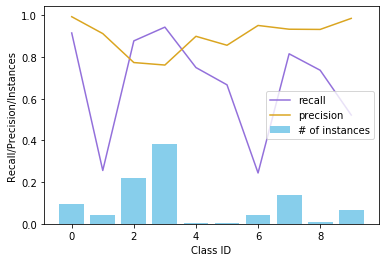

In [22]:
plt.plot(recall,color="mediumpurple")
plt.plot(precision,color="goldenrod")
plt.bar(list(labels.index),labels[0]/sum(labels[0]),color="skyblue")
leg = plt.legend(["recall","precision","# of instances"],loc=5)
plt.xlabel("Class ID")
plt.ylabel("Recall/Precision/Instances")

In [23]:
#Building times
print("Preprocesssing Time: ",ch_time_preprocessing)
print("RF Building Time n_tree=50 :",ch_time_rf_build1)
print("RF Building Time n_tree=200 :",ch_time_rf_build2)
print("MLP Building Time (16,16) :",ch_time_mlp_build1)
print("MLP Building Time (128,32) :",ch_time_mlp_build2)
print("RF Prediction Time n_tree=50 :",ch_time_rf_pred1)
print("RF Prediction Time n_tree=200 :",ch_time_rf_pred2)
print("MLP Prediction Time (16,16) :",ch_time_mlp_pred1)
print("MLP Prediction Time (128,32) :",ch_time_mlp_pred2)

Preprocesssing Time:  0.34073472023010254
RF Building Time n_tree=50 : 1.627255916595459
RF Building Time n_tree=200 : 6.015209674835205
MLP Building Time (16,16) : 0.2594265937805176
MLP Building Time (128,32) : 0.7440402507781982
RF Prediction Time n_tree=50 : 0.09927988052368164
RF Prediction Time n_tree=200 : 0.15658140182495117
MLP Prediction Time (16,16) : 0.08078765869140625
MLP Prediction Time (128,32) : 0.08377528190612793


# HOG-Features
as "powerful" approach to image feature extraction we selected HOG-Features because knowledge on these features was already present in our group.

In [24]:
hog_train = []
hog_test = []
print("Starting HOG Feature Extraction.... (approx 40 seconds)")
print("Train set feature Extraction...")
start= time.time()

for i in X_train:
    i = i.resize((64, 64))
    hog_features = hog(i, orientations=8, pixels_per_cell=(4,4),
                    cells_per_block=(1, 1), visualize=False, multichannel=True)
    hog_train.append((hog_features))
    print('█', end = '')
print("Done!")
print("Test set feature extraction....")
for i in X_test:
    i = i.resize((64, 64))
    hog_features = hog(i, orientations=8, pixels_per_cell=(4,4),
                    cells_per_block=(1, 1), visualize=False, multichannel=True)
    hog_test.append((hog_features))
    print('█', end = '')
    
end = time.time()
hog_time_preprocessing = end-start
    
print("Done!")
print("Complete!")
tr = np.array(hog_train)
te = np.array(hog_test)
print("Train shape: ", tr.shape)
print("test shape: ", te.shape)

Starting HOG Feature Extraction.... (approx 40 seconds)
Train set feature Extraction...
████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

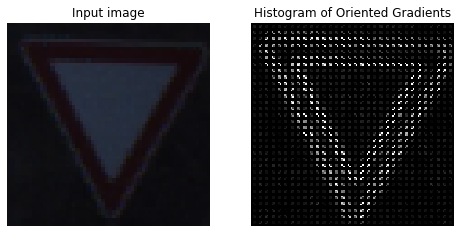

In [25]:
#What are HOG Features? Quick Visualization:
i = X_train[0]
i = i.resize((128, 128))
hog_features = hog(i, orientations=8, pixels_per_cell=(4,4),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(X_train[0].resize((128,128)), cmap=plt.cm.gray)
ax1.set_title('Input image')

hog_image_rescaled = exposure.rescale_intensity(hog_features[1], in_range=(0, 10))
ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [26]:
start = time.time()
hog_rf1 = RandomForestClassifier(n_estimators = 50, random_state = 42)
hog_rf1.fit(hog_train,y_train)

end = time.time()
hog_time_rf_build1 = end-start


start = time.time()
hog_rf_pred1 = hog_rf1.predict(hog_test)
end = time.time()
hog_time_rf_pred1 = end-start

In [27]:
start = time.time()
hog_rf2 = RandomForestClassifier(n_estimators = 200, random_state = 42)
hog_rf2.fit(hog_train,y_train)

end = time.time()
hog_time_rf_build2 = end-start


start = time.time()
hog_rf_pred2 = hog_rf2.predict(hog_test)
end = time.time()
hog_time_rf_pred2 = end-start

In [28]:
start = time.time()
hog_mlp1 = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(16,16),random_state=42)
hog_mlp1.fit(hog_train, y_train)

end = time.time()
hog_time_mlp_build1 = end-start


start = time.time()
hog_mlp_pred1 = hog_mlp1.predict(hog_test)
end = time.time()
hog_time_mlp_pred1 = end-start

In [29]:
start = time.time()
hog_mlp2 = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(128, 32), random_state=42)
hog_mlp2.fit(hog_train, y_train)

end = time.time()
hog_time_mlp_build2 = end-start


start = time.time()
hog_mlp_pred2 = hog_mlp2.predict(hog_test)
end = time.time()
hog_time_mlp_pred2 = end-start

In [30]:
print(accuracy_score(hog_rf_pred1,y_test))
print(accuracy_score(hog_rf_pred2,y_test))
print("********")
print(accuracy_score(hog_mlp_pred1,y_test))
print(accuracy_score(hog_mlp_pred2,y_test))

0.9810662680617838
0.9830592924763328
********
0.9945191828599901
0.9915296462381664


In [31]:
confusion_matrix(y_test, hog_rf_pred2)

array([[189,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  71,   1,   0,   0,   0,   0,   0,   0,   9],
       [  0,   0, 440,   1,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 767,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   2,   9,   0,   0,   0,   0,   0],
       [  0,   0,   2,   0,   0,   6,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  80,   1,   0,   0],
       [  0,   0,   5,   5,   0,   0,   0, 266,   0,   0],
       [  0,   1,   0,   0,   0,   0,   0,   0,  11,   6],
       [  0,   0,   0,   1,   0,   0,   0,   0,   0, 134]], dtype=int64)

In [32]:
confusion_matrix(y_test, hog_mlp_pred2)

array([[189,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  78,   0,   0,   0,   0,   0,   0,   0,   3],
       [  0,   0, 438,   0,   0,   1,   0,   1,   1,   0],
       [  1,   0,   0, 765,   0,   0,   0,   1,   0,   0],
       [  0,   0,   0,   2,   9,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   6,   2,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  81,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   2, 274,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  16,   2],
       [  0,   0,   0,   0,   0,   0,   0,   0,   1, 134]], dtype=int64)

In [33]:
#Building times
print("Preprocesssing Time: ",hog_time_preprocessing)
print("RF Building Time n_tree=50 :",hog_time_rf_build1)
print("RF Building Time n_tree=200 :",hog_time_rf_build2)
print("MLP Building Time (16,16) :",hog_time_mlp_build1)
print("MLP Building Time (128,32) :",hog_time_mlp_build2)
print("RF Prediction Time n_tree=50 :",hog_time_rf_pred1)
print("RF Prediction Time n_tree=200 :",hog_time_rf_pred2)
print("MLP Prediction Time (16,16) :",hog_time_mlp_pred1)
print("MLP Prediction Time (128,32) :",hog_time_mlp_pred2)

Preprocesssing Time:  36.84257125854492
RF Building Time n_tree=50 : 3.2006146907806396
RF Building Time n_tree=200 : 13.196448802947998
MLP Building Time (16,16) : 1.142469882965088
MLP Building Time (128,32) : 3.965416431427002
RF Prediction Time n_tree=50 : 0.031914472579956055
RF Prediction Time n_tree=200 : 0.10671401023864746
MLP Prediction Time (16,16) : 0.026927947998046875
MLP Prediction Time (128,32) : 0.03291177749633789


## Convolutional Neural Network


In [34]:
start = time.time()
images = []

for i in range (0,len(image_list)):
    images.append(np.array(image_list[i].resize((30, 30))))
    
images = np.array(images)

for i in range (0,len(images)):
    images[i] = images[i].astype('float32')
    images[i] = images[i] / 255

end = time.time()
cnn_preprocessing_time = end-start
print(cnn_preprocessing_time)

0.25282835960388184


In [35]:
X_train, X_test, y_train, y_test = train_test_split(images, target, test_size=0.3, random_state=42,  stratify = target)

In [36]:
cnn_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3])
cnn_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], X_test.shape[3])

input_shape = cnn_train.shape[1:]

In [37]:
def createCNN():
    model = Sequential()
    model.add(Conv2D(8, (5, 5), input_shape=input_shape,activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (3, 3), activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(16, (3, 3), activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation="relu"))
    model.add(Dense(10, activation="softmax"))
    return model

In [38]:
model = createCNN()
model_augmented = createCNN()

In [39]:
loss = 'sparse_categorical_crossentropy' 
model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
model_augmented.compile(loss=loss, optimizer='adam', metrics=['accuracy'])

In [40]:

start = time.time()
history = model.fit(cnn_train, y_train, batch_size=64, epochs=10)
end = time.time()
cnn1_build_time = end-start

Epoch 1/10
4681/4681 [==============================] - 2s 396us/step - loss: 1.4626 - accuracy: 0.4922
Epoch 2/10
4681/4681 [==============================] - 1s 288us/step - loss: 1.2302 - accuracy: 0.5663
Epoch 3/10
4681/4681 [==============================] - 1s 287us/step - loss: 1.1660 - accuracy: 0.5828
Epoch 4/10
4681/4681 [==============================] - 1s 288us/step - loss: 1.1430 - accuracy: 0.5858
Epoch 5/10
4681/4681 [==============================] - 1s 287us/step - loss: 1.1101 - accuracy: 0.6020
Epoch 6/10
4681/4681 [==============================] - 1s 289us/step - loss: 1.0967 - accuracy: 0.6022
Epoch 7/10
4681/4681 [==============================] - 1s 290us/step - loss: 1.0864 - accuracy: 0.6054
Epoch 8/10
4681/4681 [==============================] - 1s 288us/step - loss: 1.0621 - accuracy: 0.6174
Epoch 9/10
4681/4681 [==============================] - 1s 288us/step - loss: 1.0513 - accuracy: 0.6251
Epoch 10/10
4681/4681 [==============================] - 1s 289u

In [41]:
data_aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False)

start = time.time()
history_augmented = model_augmented.fit_generator(data_aug.flow(cnn_train, y_train, 
                                                                batch_size=64), steps_per_epoch=480, epochs=10)
end=time.time()
cnn2_build_time = end-start

Epoch 1/10
480/480 [==============================] - 13s 27ms/step - loss: 1.3432 - accuracy: 0.5248
Epoch 2/10
480/480 [==============================] - 13s 27ms/step - loss: 1.2162 - accuracy: 0.5652
Epoch 3/10
480/480 [==============================] - 13s 27ms/step - loss: 1.2186 - accuracy: 0.5705
Epoch 4/10
480/480 [==============================] - 13s 27ms/step - loss: 1.1726 - accuracy: 0.5818
Epoch 5/10
480/480 [==============================] - 13s 26ms/step - loss: 1.1588 - accuracy: 0.5852
Epoch 6/10
480/480 [==============================] - 13s 27ms/step - loss: 1.1392 - accuracy: 0.5913
Epoch 7/10
480/480 [==============================] - 13s 27ms/step - loss: 1.1261 - accuracy: 0.5938
Epoch 8/10
480/480 [==============================] - 13s 27ms/step - loss: 1.1191 - accuracy: 0.5995
Epoch 9/10
480/480 [==============================] - 13s 27ms/step - loss: 1.1322 - accuracy: 0.5956
Epoch 10/10
480/480 [==============================] - 13s 27ms/step - loss: 1.110

In [42]:
start = time.time()
test_pred = model.predict_classes(cnn_test)
end = time.time()
cnn1_pred_time = end-start

start = time.time()
test_pred_augmented = model_augmented.predict_classes(cnn_test)
end = time.time()
cnn2_pred_time = end-start

In [43]:
print(sum(test_pred==y_test)/len(y_test))
print(sum(test_pred_augmented==y_test)/len(y_test))

0.5979073243647235
0.4838066766317887


In [44]:
print(cnn1_build_time)
print(cnn2_build_time)

14.995482683181763
129.89383220672607


In [45]:
print(cnn1_pred_time)
print(cnn2_pred_time)

0.3979918956756592
0.3770029544830322


# Fruits Dataset

## Preliminaries

In [46]:
imgPath="./FIDS30"
os.chdir(owd)
os.chdir(imgPath)

In [47]:
imgFiles = glob.glob("*/*.jpg")

In [48]:
image_list = []
for filename in imgFiles:
    im=Image.open(filename)
    image_list.append(im)

In [49]:
fileNames = glob.glob("*/*.jpg")
numberOfFiles=len(fileNames)
targetLabels=[]

print("Found " + str(numberOfFiles) + " files\n")


for fileName in fileNames:

    pathSepIndex = fileName.index("\\")
    targetLabels.append(fileName[:pathSepIndex])

# sk-learn can only handle labels in numeric format - we have them as strings though...
# Thus we use the LabelEncoder, which does a mapping to Integer numbers
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(targetLabels) # this basically finds all unique class names, and assigns them to the numbers
print("Found the following classes: " + str(list(le.classes_)))

# now we transform our labels to integers
target = le.transform(targetLabels); 
print("Transformed labels (first elements: " + str(target[0:150]))

# If we want to find again the label for an integer value, we can do something like this:
# print list(le.inverse_transform([0, 18, 1]))

print("... done label encoding")

Found 971 files

Found the following classes: ['acerolas', 'apples', 'apricots', 'avocados', 'bananas', 'blackberries', 'blueberries', 'cantaloupes', 'cherries', 'coconuts', 'figs', 'grapefruits', 'grapes', 'guava', 'kiwifruit', 'lemons', 'limes', 'mangos', 'olives', 'oranges', 'passionfruit', 'peaches', 'pears', 'pineapples', 'plums', 'pomegranates', 'raspberries', 'strawberries', 'tomatoes', 'watermelons']
Transformed labels (first elements: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4]
... done label encoding


## Data Exploration

In [50]:
h = []
w = []
for i in image_list:
    width, height = i.size
    h.append(height)
    w.append(width)

{'whiskers': [<matplotlib.lines.Line2D at 0x230141a4648>,
 'caps': [<matplotlib.lines.Line2D at 0x230141a4d88>,
 'boxes': [<matplotlib.lines.Line2D at 0x2301419cd88>],
 'medians': [<matplotlib.lines.Line2D at 0x230141a8f48>],
 'fliers': [<matplotlib.lines.Line2D at 0x230141a8ac8>],
 'means': []}

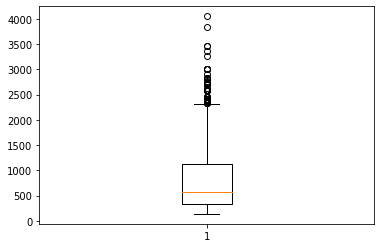

In [51]:
plt.boxplot(h)

In [52]:
max(w)

5814

Text(0, 0.5, 'Relative Class Frequency [%]')

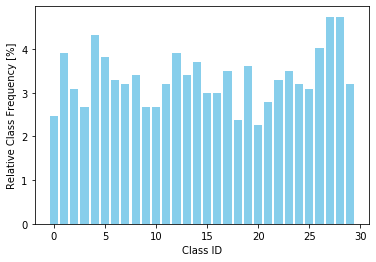

In [53]:
labels = list(map(int, target))
labels = pd.DataFrame(labels)
labels = labels[0].value_counts()
labels = pd.DataFrame(labels)
labels = labels.sort_index(axis=0)
plt.bar(list(labels.index),labels[0]/len(target)*100,color="skyblue")
plt.xlabel ("Class ID")
plt.ylabel ("Relative Class Frequency [%]")

In [54]:
max(labels[0])

46

## Sampling

In [55]:
X_train, X_test, y_train, y_test = train_test_split(image_list, target, test_size=0.3, random_state=42, stratify=target)

In [56]:
print(len(X_train))
print(len(X_test))

679
292


## Colour Histogram

In [57]:
ch_train = []
ch_test = []
start = time.time()
for i in X_train:

    imagePIL = i.convert('RGB')     
    featureVector=imagePIL.histogram()
    ch_train.append((featureVector))
    
for i in X_test:

    imagePIL = i.convert('RGB')     
    featureVector=imagePIL.histogram()
    ch_test.append((featureVector))
end = time.time()
ch_time_preprocessing = end-start

In [58]:
start = time.time()
ch_rf1 = RandomForestClassifier(n_estimators = 50, random_state = 42)
ch_rf1.fit(ch_train,y_train)
end = time.time()
ch_time_rf_build1 = end-start

start = time.time()
ch_rf_pred1 = ch_rf1.predict(ch_test)
end = time.time()
ch_time_rf_pred1 = end-start

In [59]:
start = time.time()
ch_rf2 = RandomForestClassifier(n_estimators = 200, random_state = 42)
ch_rf2.fit(ch_train,y_train)
end = time.time()
ch_time_rf_build2 = end-start

start = time.time()
ch_rf_pred2 = ch_rf2.predict(ch_test)
end = time.time()
ch_time_rf_pred2 = end-start

In [60]:
start = time.time()

ch_mlp1 = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(16, 16), random_state=42)

ch_mlp1.fit(ch_train, y_train)

end = time.time()
ch_time_mlp_build1 = end-start

start = time.time()
ch_mlp_pred1 = ch_mlp1.predict(ch_test)
end = time.time()
ch_time_mlp_pred1 = end-start

In [61]:
start = time.time()

ch_mlp2 = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(126, 32), random_state=42)

ch_mlp2.fit(ch_train, y_train)

end = time.time()
ch_time_mlp_build2 = end-start

start = time.time()
ch_mlp_pred2 = ch_mlp2.predict(ch_test)
end = time.time()
ch_time_mlp_pred2 = end-start

In [62]:
print(accuracy_score(ch_rf_pred1,y_test))
print(accuracy_score(ch_rf_pred2,y_test))
print("********")
print(accuracy_score(ch_mlp_pred1,y_test))
print(accuracy_score(ch_mlp_pred2,y_test))

#Building times
print("Preprocesssing Time: ",ch_time_preprocessing)
print("RF Building Time n_tree=50 :",ch_time_rf_build1)
print("RF Building Time n_tree=200 :",ch_time_rf_build2)
print("MLP Building Time (16,16) :",ch_time_mlp_build1)
print("MLP Building Time (128,32) :",ch_time_mlp_build2)
print("RF Prediction Time n_tree=50 :",ch_time_rf_pred1)
print("RF Prediction Time n_tree=200 :",ch_time_rf_pred2)
print("MLP Prediction Time (16,16) :",ch_time_mlp_pred1)
print("MLP Prediction Time (128,32) :",ch_time_mlp_pred2)

0.22945205479452055
0.2534246575342466
********
0.03424657534246575
0.030821917808219176
Preprocesssing Time:  24.92235493659973
RF Building Time n_tree=50 : 0.6283295154571533
RF Building Time n_tree=200 : 2.4215621948242188
MLP Building Time (16,16) : 0.20695233345031738
MLP Building Time (128,32) : 0.3819866180419922
RF Prediction Time n_tree=50 : 0.01795220375061035
RF Prediction Time n_tree=200 : 0.03690171241760254
MLP Prediction Time (16,16) : 0.0109710693359375
MLP Prediction Time (128,32) : 0.014960050582885742


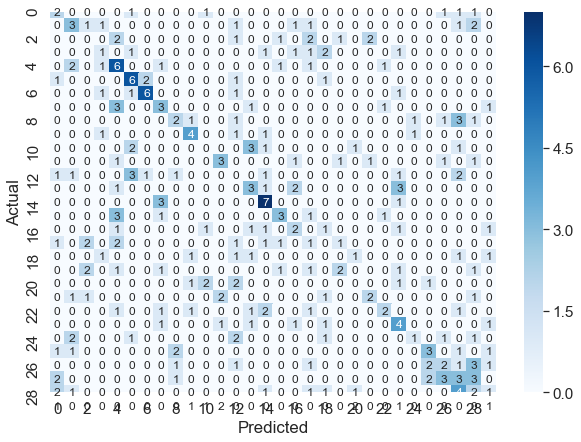

In [63]:
data = confusion_matrix(y_test, ch_rf_pred2)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 12})# font size

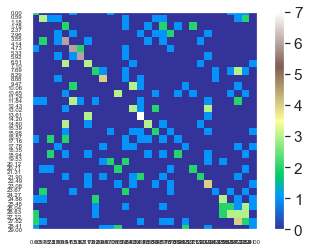

In [64]:
p = pd.Series(list(map(int,ch_rf_pred2)))
t = pd.Series(list(map(int,y_test)))
confmat = pd.crosstab(t, p,rownames=["Actual"], colnames=["Predicted"])


ticks=np.linspace(0, 29)
plt.imshow(confmat, interpolation="none",cmap="terrain")
plt.colorbar()
plt.xticks(ticks,fontsize=6)
plt.yticks(ticks,fontsize=6)
plt.grid(False)
plt.show()

In [65]:
np.unique(np.array(targetLabels))

array(['acerolas', 'apples', 'apricots', 'avocados', 'bananas',
       'blackberries', 'blueberries', 'cantaloupes', 'cherries',
       'coconuts', 'figs', 'grapefruits', 'grapes', 'guava', 'kiwifruit',
       'lemons', 'limes', 'mangos', 'olives', 'oranges', 'passionfruit',
       'peaches', 'pears', 'pineapples', 'plums', 'pomegranates',
       'raspberries', 'strawberries', 'tomatoes', 'watermelons'],
      dtype='<U12')

## HOG Features

In [66]:
hog_train = []
hog_test = []
print("Starting HOG Feature Extraction.... (approx  seconds)")
print("Train set feature Extraction...")
start= time.time()

for i in X_train:
    i = i.resize((256, 256))
    hog_features = hog(i, orientations=8, pixels_per_cell=(16,16),
                    cells_per_block=(2, 2), visualize=False, multichannel=True)
    hog_train.append((hog_features))
    print('█', end = '')
print("Done!")
print("Test set feature extraction....")
for i in X_test:
    i = i.resize((256,256))
    hog_features = hog(i, orientations=8, pixels_per_cell=(16,16),
                    cells_per_block=(2, 2), visualize=False, multichannel=True)
    hog_test.append((hog_features))
    print('█', end = '')
    
end = time.time()
hog_time_preprocessing = end-start
    
print("Done!")
print("Complete!")
tr = np.array(hog_train)
te = np.array(hog_test)
print("Train shape: ", tr.shape)
print("test shape: ", te.shape)

Starting HOG Feature Extraction.... (approx  seconds)
Train set feature Extraction...
███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████Done!
Test set feature extraction....
█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

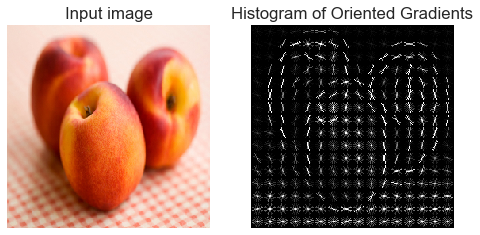

In [67]:
#What are HOG Features? Quick Visualization:
i = X_train[0]
i = i.resize((256,256))
hog_features = hog(i, orientations=8, pixels_per_cell=(16,16),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(X_train[0].resize((256,256)), cmap=plt.cm.gray)
ax1.set_title('Input image')

hog_image_rescaled = exposure.rescale_intensity(hog_features[1], in_range=(0, 10))
ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

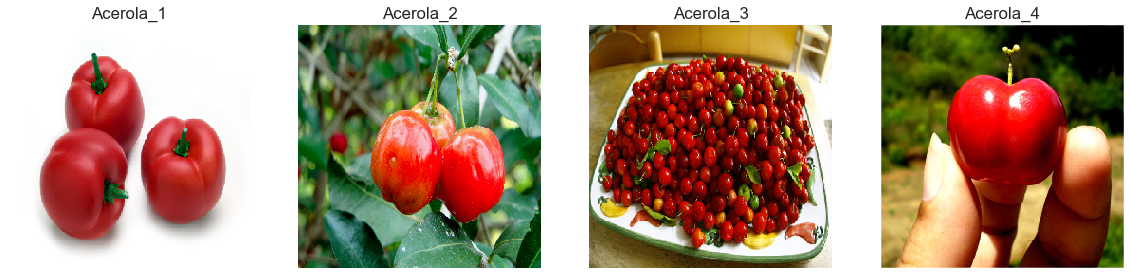

In [68]:
#What are HOG Features? Quick Visualization:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 10), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image_list[0].resize((256,256)), cmap=plt.cm.gray)
ax1.set_title('Acerola_1')

ax2.axis('off')
ax2.imshow(image_list[1].resize((256,256)), cmap=plt.cm.gray)
ax2.set_title('Acerola_2')

ax3.axis('off')
ax3.imshow(image_list[2].resize((256,256)), cmap=plt.cm.gray)
ax3.set_title('Acerola_3')

ax4.axis('off')
ax4.imshow(image_list[4].resize((256,256)), cmap=plt.cm.gray)
ax4.set_title('Acerola_4')

plt.show()

In [69]:
start = time.time()
hog_rf1 = RandomForestClassifier(n_estimators = 50, random_state = 42)
hog_rf1.fit(hog_train,y_train)

end = time.time()
hog_time_rf_build1 = end-start


start = time.time()
hog_rf_pred1 = hog_rf1.predict(hog_test)
end = time.time()
hog_time_rf_pred1 = end-start

In [70]:
start = time.time()
hog_rf2 = RandomForestClassifier(n_estimators = 200, random_state = 42)
hog_rf2.fit(hog_train,y_train)

end = time.time()
hog_time_rf_build2 = end-start


start = time.time()
hog_rf_pred2 = hog_rf2.predict(hog_test)
end = time.time()
hog_time_rf_pred2 = end-start

In [71]:
start = time.time()

hog_mlp1 = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(16, 16), random_state=42)

hog_mlp1.fit(hog_train, y_train)

end = time.time()
hog_time_mlp_build1 = end-start

start = time.time()
hog_mlp_pred1 = hog_mlp1.predict(hog_test)
end = time.time()
hog_time_mlp_pred1 = end-start

In [72]:
start = time.time()

hog_mlp2 = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(128, 32), random_state=42)

hog_mlp2.fit(hog_train, y_train)

end = time.time()
hog_time_mlp_build2 = end-start

start = time.time()
hog_mlp_pred2 = hog_mlp2.predict(hog_test)
end = time.time()
hog_time_mlp_pred2 = end-start

In [73]:
print(accuracy_score(hog_rf_pred1,y_test))
print(accuracy_score(hog_rf_pred2,y_test))
print("********")
print(accuracy_score(hog_mlp_pred1,y_test))
print(accuracy_score(hog_mlp_pred2,y_test))


#Building times
print("Preprocesssing Time: ",hog_time_preprocessing)
print("RF Building Time n_tree=50 :",hog_time_rf_build1)
print("RF Building Time n_tree=200 :",hog_time_rf_build2)
print("MLP Building Time (16,16) :",hog_time_mlp_build1)
print("MLP Building Time (128,32) :",hog_time_mlp_build2)
print("RF Prediction Time n_tree=50 :",hog_time_rf_pred1)
print("RF Prediction Time n_tree=200 :",hog_time_rf_pred2)
print("MLP Prediction Time (16,16) :",hog_time_mlp_pred1)
print("MLP Prediction Time (128,32) :",hog_time_mlp_pred2)

0.136986301369863
0.13356164383561644
********
0.08904109589041095
0.10616438356164383
Preprocesssing Time:  15.895769596099854
RF Building Time n_tree=50 : 2.8640592098236084
RF Building Time n_tree=200 : 11.79086446762085
MLP Building Time (16,16) : 2.556797981262207
MLP Building Time (128,32) : 12.610865592956543
RF Prediction Time n_tree=50 : 0.014960050582885742
RF Prediction Time n_tree=200 : 0.04089164733886719
MLP Prediction Time (16,16) : 0.011968135833740234
MLP Prediction Time (128,32) : 0.014960050582885742


In [74]:
len(target)

971

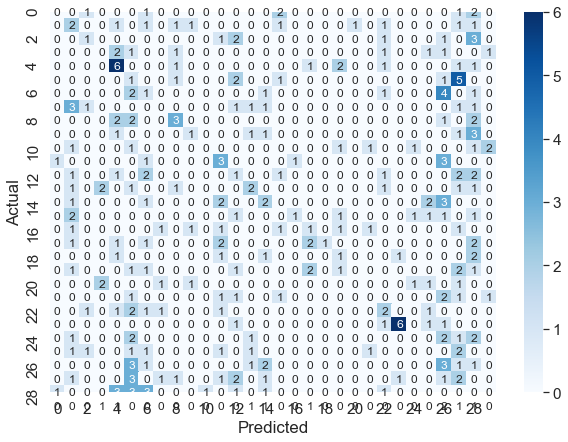

In [75]:
data = confusion_matrix(y_test, hog_rf_pred2)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 12})# font size

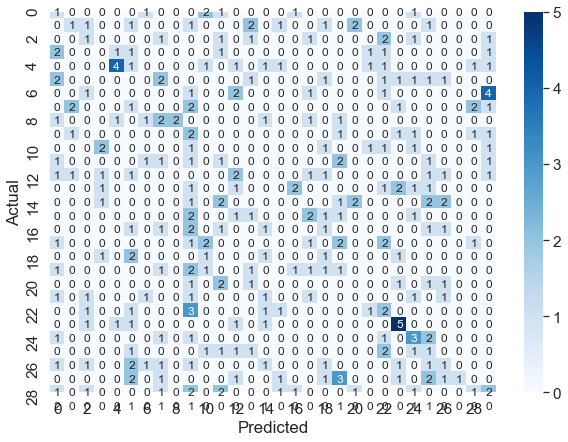

In [76]:
data = confusion_matrix(y_test, hog_mlp_pred2)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 12})# font size

In [77]:
np.unique(np.array(targetLabels))

array(['acerolas', 'apples', 'apricots', 'avocados', 'bananas',
       'blackberries', 'blueberries', 'cantaloupes', 'cherries',
       'coconuts', 'figs', 'grapefruits', 'grapes', 'guava', 'kiwifruit',
       'lemons', 'limes', 'mangos', 'olives', 'oranges', 'passionfruit',
       'peaches', 'pears', 'pineapples', 'plums', 'pomegranates',
       'raspberries', 'strawberries', 'tomatoes', 'watermelons'],
      dtype='<U12')

## CNN

In [79]:
start = time.time()
images = []

for i in range (0,len(image_list)):
    images.append(np.array(image_list[i].resize((30, 30))))

# small error with image 153 (banana)
# not the same shape as the others - we remove it in the next step

#for i in range (0,len(image_list)):
#    if images[i].shape != (30, 30, 3):
#        print(i)
    
images.pop(153)
target_new = target.copy()
target_new = np.delete(target_new,153)
images = np.array(images)

for i in range (0,len(images)):
    images[i] = images[i].astype('float32')
    images[i] = images[i] / 255

end = time.time()
cnn_preprocessing_time = end-start
print(cnn_preprocessing_time)

0.044907569885253906


In [80]:
X_train, X_test, y_train, y_test = train_test_split(images, target_new, test_size=0.3, random_state=42,  stratify = target_new)

In [81]:
cnn_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3])
cnn_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], X_test.shape[3])

input_shape = cnn_train.shape[1:]

In [82]:
def createCNN():
    model=Sequential()
    model.add(Conv2D(filters=8,kernel_size=(5,5),padding="Same",activation="relu",input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=16,kernel_size=(4,4),padding="Same",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=32,kernel_size=(4,4),padding="Same",activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512,activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(30,activation="softmax"))
    return model

In [83]:
model = createCNN()
model_augmented = createCNN()

In [84]:
loss = 'sparse_categorical_crossentropy' 
model.compile(loss=loss, optimizer=Adam(lr=0.001,beta_1=0.9,beta_2=0.999), metrics=['accuracy'])
model_augmented.compile(loss=loss, optimizer=Adam(lr=0.001,beta_1=0.9,beta_2=0.999), metrics=['accuracy'])

In [85]:
start = time.time()
history = model.fit(cnn_train, y_train, epochs=10)
end = time.time()
cnn1_build_time = end-start

Epoch 1/10
679/679 [==============================] - 0s 508us/step - loss: 3.3991 - accuracy: 0.0412
Epoch 2/10
679/679 [==============================] - 0s 353us/step - loss: 3.3699 - accuracy: 0.0353
Epoch 3/10
679/679 [==============================] - 0s 333us/step - loss: 3.3379 - accuracy: 0.0722
Epoch 4/10
679/679 [==============================] - 0s 339us/step - loss: 3.3061 - accuracy: 0.0677
Epoch 5/10
679/679 [==============================] - 0s 355us/step - loss: 3.2511 - accuracy: 0.0854
Epoch 6/10
679/679 [==============================] - 0s 343us/step - loss: 3.2061 - accuracy: 0.0987
Epoch 7/10
679/679 [==============================] - 0s 338us/step - loss: 3.1476 - accuracy: 0.1193
Epoch 8/10
679/679 [==============================] - 0s 330us/step - loss: 3.1012 - accuracy: 0.1208
Epoch 9/10
679/679 [==============================] - 0s 335us/step - loss: 3.0676 - accuracy: 0.1163
Epoch 10/10
679/679 [==============================] - 0s 330us/step - loss: 3.048

In [86]:
data_aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False)

start = time.time()
history_augmented = model_augmented.fit_generator(data_aug.flow(cnn_train, y_train, 
                                                                batch_size=64), steps_per_epoch=60, epochs=10)
end = time.time()
cnn2_build_time = end-start

Epoch 1/10
60/60 [==============================] - 2s 28ms/step - loss: 3.3573 - accuracy: 0.0538
Epoch 2/10
60/60 [==============================] - 2s 27ms/step - loss: 3.1970 - accuracy: 0.0962
Epoch 3/10
60/60 [==============================] - ETA: 0s - loss: 3.0884 - accuracy: 0.11 - 2s 28ms/step - loss: 3.0864 - accuracy: 0.1122
Epoch 4/10
60/60 [==============================] - 2s 27ms/step - loss: 2.9966 - accuracy: 0.1378
Epoch 5/10
60/60 [==============================] - 2s 28ms/step - loss: 2.9319 - accuracy: 0.1553
Epoch 6/10
60/60 [==============================] - 2s 27ms/step - loss: 2.8598 - accuracy: 0.1653
Epoch 7/10
60/60 [==============================] - 2s 28ms/step - loss: 2.7793 - accuracy: 0.1838
Epoch 8/10
60/60 [==============================] - 2s 27ms/step - loss: 2.7091 - accuracy: 0.2051
Epoch 9/10
60/60 [==============================] - 2s 27ms/step - loss: 2.6549 - accuracy: 0.2254
Epoch 10/10
60/60 [==============================] - 2s 28ms/step -

In [87]:
start = time.time()
test_pred = model.predict_classes(cnn_test)
end = time.time()
cnn1_pred_time = end-start


start = time.time()
test_pred_augmented = model_augmented.predict_classes(cnn_test)
end = time.time()
cnn2_pred_time = end-start

In [88]:
print(sum(test_pred==y_test)/len(y_test))
print(sum(test_pred_augmented==y_test)/len(y_test))

0.11683848797250859
0.13058419243986255


In [89]:
print(cnn_preprocessing_time)
print(cnn1_build_time)
print(cnn2_build_time)
print(cnn1_pred_time)
print(cnn2_pred_time)

0.044907569885253906
2.6271233558654785
16.787578344345093
0.08773922920227051
0.07480001449584961
